In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import norm
from scipy import integrate, stats
import scipy
import time
import warnings
import copy
import pandas as pd
import seaborn as sns
from prettytable import PrettyTable
from numpy import random
import random as rnd
import math
from tqdm import tqdm 
import tabulate
from numba import njit, jit
from numpy.linalg import solve

warnings.filterwarnings("ignore", category = RuntimeWarning)

In [59]:
@jit(nopython=True)
def FDM(t_steps, x_steps, S0, K=110, sigma=0.3, r=0.04, T=1, scheme='FTCS', maxfactor=None, constant=500):
    assert scheme in ['CN','FTCS','BTCS'], 'Scheme should be "CN","FTCS" or "BTCS"'
    if maxfactor!=None:
        Smax = maxfactor*S0
    else:
        Smax = constant

    x_max = np.log(Smax)
    x_min = np.log(0.001)
    X= np.linspace(x_min,x_max,x_steps+1)
    dx = X[1] - X[0]
    dtau = T/t_steps
    tau = np.arange(t_steps+1)*dtau
    
    V = np.zeros((t_steps+1,x_steps+1))
    V[0, :] = [max(np.exp(s)-K,0) for s in X]
    A = None
    if scheme=='FTCS':
        aminus1 = 0.5*dtau*(sigma**2/dx**2 - (r-0.5*sigma**2)/dx)
        a0 = 1 - dtau*(sigma**2/dx**2 + r)
        aplus1 = 0.5*dtau*(sigma**2/dx**2 + (r-0.5*sigma**2)/dx)
        A = aminus1*np.eye(x_steps+1,k=-1) + a0*np.eye(x_steps+1) + aplus1*np.eye(x_steps+1,k=1)
        A[0,0]=0; A[0,1]=0; A[-1,-1] = 0; A[-1,-2] = 0
        #B = np.identity(x_steps+1) we remove it to improve computational times
        for i in range(t_steps):
            V_ = np.dot(A,V[i, :])
            V_[0] = 0 ; V_[-1] = Smax - K*np.exp(-r*tau[i])
            V[i+1, :] = V_ 
        
    elif scheme=='CN':
        aminus1 = 0.25*dtau*(sigma**2/dx**2 - (r-0.5*sigma**2)/dx)
        a0 = 1 - dtau*0.5*(sigma**2/dx**2 + r)
        aplus1 = 0.25*dtau*(sigma**2/dx**2 + (r-0.5*sigma**2)/dx)
        A = aminus1*np.eye(x_steps+1,k=-1) + a0*np.eye(x_steps+1) + aplus1*np.eye(x_steps+1,k=1)
        B = 2*np.identity(x_steps+1) - A
        A[0,0]=0; A[0,1]=0; A[-1,-1] = 0; A[-1,-2] = 0
        B[0,0]=1; B[0,1]=0; B[-1,-1] = 1; B[-1,-2] = 0
        for i in range(t_steps):
            V_ = np.dot(A,V[i, :])
            V_[0] = 0 ; V_[-1] = Smax - K*np.exp(-r*tau[i])
            V[i+1, :] = solve(B,V_) 
          
    V_S0 = np.interp(S0, np.exp(X), V[-1,:])  
    return V_S0, V[-1], tau, X, V 

def blackschol(S0, K=110, sigma=0.3, r=0.04, T=1, optiontype='call'):
    assert optiontype in ['call','put'], 'optiontype should be either "call" or "put".'
    d1 = (1 / (sigma * np.sqrt(T)))*( np.log(S0/K) + (r + (sigma**2/2))*(T))
    d2 = (1 / (sigma * np.sqrt(T)))*( np.log(S0/K) + (r - (sigma**2/2))*(T))
    
    if optiontype == 'call':
        value = norm.cdf(d1)* S0 - norm.cdf(d2)* K * np.exp(-r *(T))
        delta = norm.cdf(d1)
    elif optiontype == 'put':
        value = norm.cdf(-1*d2) * K * np.exp(-r *(T))  - norm.cdf(-1*d1)* S0 
        delta = norm.cdf(d1) - 1
    
    return value, delta

In [ ]:
# using optimal grid sizes as determined above
ftcs100= FDM(t_steps=61, x_steps=331, S0=100)
ftcs110= FDM(t_steps=61, x_steps=331, S0=110)
ftcs120= FDM(t_steps=61, x_steps=331, S0=120)
cn100= FDM(t_steps=61, x_steps=331, S0=100,scheme="CN")
cn110= FDM(t_steps=61, x_steps=331, S0=110,scheme="CN")
cn120= FDM(t_steps=61, x_steps=331, S0=120,scheme="CN")

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, dpi=200)
x_ax, y_ax = np.meshgrid(ftcs100[2], np.exp(ftcs100[3]))
z_ax = np.transpose(ftcs100[4])
surf = ax.plot_surface(x_ax, y_ax, z_ax, cmap=cm.viridis)
fig.colorbar(surf, shrink=0.5, aspect=10,pad=0.08)
ax.set_xlabel(r"$\tau$")
ax.set_ylabel("S")
ax.set_zlabel("V")
ax.set_title("Option pricing using FTCS scheme")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, dpi=200)
x_ax, y_ax = np.meshgrid(cn100[2], np.exp(cn100[3]))
z_ax = np.transpose(cn100[4])
surf = ax.plot_surface(x_ax, y_ax, z_ax, cmap=cm.viridis)
fig.colorbar(surf, shrink=0.5, aspect=10, pad=0.08)
ax.set_xlabel(r"$\tau$")
ax.set_ylabel("S")
ax.set_zlabel("V")
ax.set_title("Option pricing using CN scheme")
plt.tight_layout()
plt.show()

## Experiment when $S_{max}$ is set dynamically to $S_{max} = factor\times S_0$

In [ ]:
bs100 = blackschol(S0=100)[0]
bs110 = blackschol(S0=110)[0]
bs120 = blackschol(S0=120)[0]

min_time_fd100 = min_time_cn100 = min_time_fd110 = min_time_cn110 = min_time_fd120 = min_time_cn120 = 10**5

mesh_fac = {'S0=100':[[],[]], 'S0=110':[[], []], 'S0=120':[[],[]]}  # 0 index for FTCS, 1 for CN

for fac in range(3,11,1):
    for t in tqdm(range(1,500, 2)):
        for x in range(1,500, 4):
            t_fd100 = time.time()
            fd100 = FDM(t_steps = t, x_steps = x, S0=100, maxfactor=fac)[0]
            comp_time_fd100 = time.time() - t_fd100
            t_cn100 = time.time()
            cn100 = FDM(t_steps = t, x_steps = x, S0=100, maxfactor=fac, scheme='CN')[0]
            comp_time_cn100 = time.time() - t_cn100
            fderr100 = abs(fd100 - bs100)
            cnerr100 = abs(cn100 - bs100)
            
            t_fd110 = time.time()
            fd110 = FDM(t_steps = t, x_steps = x, S0=110, maxfactor=fac)[0]
            comp_time_fd110 = time.time() - t_fd110
            t_cn110 = time.time()
            cn110 = FDM(t_steps = t, x_steps = x, S0=110, maxfactor=fac, scheme='CN')[0]
            comp_time_cn110 = time.time() - t_cn110
            fderr110 = abs(fd110 - bs110)
            cnerr110 = abs(cn110 - bs110)
            
            t_fd120 = time.time()
            fd120 = FDM(t_steps = t, x_steps = x, S0=120, maxfactor=fac)[0]
            comp_time_fd120 = time.time() - t_fd120
            t_cn120 = time.time()
            cn120 = FDM(t_steps = t, x_steps = x, S0=120, maxfactor=fac, scheme='CN')[0]
            comp_time_cn120 = time.time() - t_cn120
            fderr120 = abs(fd120 - bs120)
            cnerr120 = abs(cn120 - bs120)
                        
            if fderr100 < 10**-4:
                if comp_time_fd100 < min_time_fd100:
                    min_time_fd100 = comp_time_fd100
                    mesh_fac['S0=100'][0].append(("factor={}".format(fac),t,x,round(fderr100,6),round(comp_time_fd100,6)))

            if cnerr100 < 10**-4:
                if comp_time_cn100 < min_time_cn100:
                    min_time_cn100 = comp_time_cn100
                    mesh_fac['S0=100'][1].append(("factor={}".format(fac),t,x,round(cnerr100,6),round(comp_time_cn100,6)))
                    
            if fderr110 < 10**-4:
                if comp_time_fd110 < min_time_fd110:
                    min_time_fd110 = comp_time_fd110
                    mesh_fac['S0=110'][0].append(("factor={}".format(fac),t,x,round(fderr110,6),round(comp_time_fd110,6)))

            if cnerr110 < 10**-4:
                if comp_time_cn110 < min_time_cn110:
                    min_time_cn110 = comp_time_cn110
                    mesh_fac['S0=110'][1].append(("factor={}".format(fac),t,x,round(cnerr110,6),round(comp_time_cn110,6)))
                    
            if fderr120 < 10**-4:
                if comp_time_fd120 < min_time_fd120:
                    min_time_fd120 = comp_time_fd120
                    mesh_fac['S0=120'][0].append(("factor={}".format(fac),t,x,round(fderr120,6),round(comp_time_fd120,6)))

            if cnerr120 < 10**-4:
                if comp_time_cn120 < min_time_cn120:
                    min_time_cn120 = comp_time_cn120
                    mesh_fac['S0=120'][1].append(("factor={}".format(fac),t,x,round(cnerr120,6),round(comp_time_cn120,6)))

df_fac = pd.DataFrame.from_dict(mesh_fac)
df_fac.index = ['FTCS', 'CN']
print(df_fac)

 58%|████████████████████████████████████████████                                | 145/250 [1:29:35<2:15:24, 77.38s/it]

## When $S_{max}=\text{pre set constant}$

In [65]:
min_time_fd100 = min_time_cn100 = min_time_fd110 = min_time_cn110 = min_timefd120 = min_time_cn120 = 10**5

mesh_const = {'S0=100':[[],[]], 'S0=110':[[], []], 'S0=120':[[],[]]}  # 0 index for FTCS, 1 for CN

for const in range(300,1200,100):
    for t in tqdm(range(1,500, 1)):
        for x in range(1,500, 1):
            
            t_fd100 = time.time()
            fd100 = FDM(t_steps = t, x_steps = x, S0=100, constant = const)[0]
            comp_time_fd100 = time.time() - t_fd100
            t_cn100 = time.time()
            cn100 = FDM(t_steps = t, x_steps = x, S0=100, constant = const, scheme='CN')[0]
            comp_time_cn100 = time.time() - t_cn100
            fderr100 = abs(fd100 - bs100)
            cnerr100 = abs(cn100 - bs100)
            
            t_fd110 = time.time()
            fd110 = FDM(t_steps = t, x_steps = x, S0=110, constant = const)[0]
            comp_time_fd110 = time.time() - t_fd110
            t_cn110 = time.time()
            cn110 = FDM(t_steps = t, x_steps = x, S0=110, constant = const, scheme='CN')[0]
            comp_time_cn110 = time.time() - t_cn110
            fderr110 = abs(fd110 - bs110)
            cnerr110 = abs(cn110 - bs110)
            
            t_fd120 = time.time()
            fd120 = FDM(t_steps = t, x_steps = x, S0=120, constant = const)[0]
            comp_time_fd120 = time.time() - t_fd120
            t_cn120 = time.time()
            cn120 = FDM(t_steps = t, x_steps = x, S0=120, constant = const, scheme='CN')[0]
            comp_time_cn120 = time.time() - t_cn120
            fderr120 = abs(fd120 - bs120)
            cnerr120 = abs(cn120 - bs120)
                        
            if fderr100 < 10**-4:
                if comp_time_fd100 < min_time_fd100:
                    min_time_fd100 = comp_time_fd100
                    mesh_const['S0=100'][0].append((t,x,round(fderr100,6),round(comp_time_fd100,6)))

            if cnerr100 < 10**-4:
                if comp_time_cn100 < min_time_cn100:
                    min_time_cn100 = comp_time_cn100
                    mesh_const['S0=100'][1].append((t,x,round(cnerr100,6),round(comp_time_cn100,6)))
               
            if fderr110 < 10**-4:
                if comp_time_fd110 < min_time_fd110:
                    min_time_fd110 = comp_time_fd110
                    mesh_const['S0=110'][0].append((t,x,round(fderr110,6),round(comp_time_fd110,6)))

            if cnerr110 < 10**-4:
                if comp_time_cn110 < min_time_cn110:
                    min_time_cn110 = comp_time_cn110
                    mesh_const['S0=110'][1].append((t,x,round(cnerr110,6),round(comp_time_cn110,6)))
                    
            if fderr120 < 10**-4:
                if comp_time_fd120 < min_time_fd120:
                    min_time_fd120 = comp_time_fd120
                    mesh_const['S0=120'][0].append((t,x,round(fderr120,6),round(comp_time_fd120,6)))

            if cnerr120 < 10**-4:
                if comp_time_cn120 < min_time_cn120:
                    min_time_cn120 = comp_time_cn120
                    mesh_const['S0=120'][1].append((t,x,round(cnerr120,6),round(comp_time_cn120,6)))

df_const = pd.DataFrame.from_dict(mesh_const)
df_const.index = ['FTCS', 'CN']
print(df_const)

 59%|████████████████████████████████████████████▍                               | 292/499 [4:03:40<2:52:44, 50.07s/it]


KeyboardInterrupt: 

## optimal grid sizes for FTCS
S0=100 -> (1, 166), (16, 171), (31, 106), (186, 481), (191, 481), (196, 481), (201, 481)
<br>S0=110 -> (11, 61), (16, 156), (46, 286), (51, 286), (106, 416), (111, 416)
<br>S0=120 ->  (1, 96), (11, 46), (11, 101), (61, 331), (66, 331), (71, 331), (76, 331), (81, 331), (86, 331), (91, 331), (96, 331), (101, 331)

## optimal grid sizes for CN (Note: These are just minimum error grid sizes because CN is anyways unconditionally stable)
S0=120 -> (1, 46), (1, 156), (1, 366), (1, 421), (1, 476)
{'FTCS': [(196, 146, 5e-05, 0.000997781753540039), (371, 251, 6e-05, 0.0)], 'CN': [(26, 311, 7e-05, 0.01011037826538086)]}

In [53]:
bs_120 = blackschol(S0=120)[0]
residuals_ftcs = []
residuals_cn = []
x_range = np.arange(100,500,1)
for x in tqdm(x_range):
    residuals_ftcs.append(abs(FDM(t_steps=100, x_steps=x, S0=120)[0] - bs_120))
    residuals_cn.append(abs(FDM(t_steps=100, x_steps=x, S0=120,scheme='CN')[0] - bs_120))

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.44it/s]


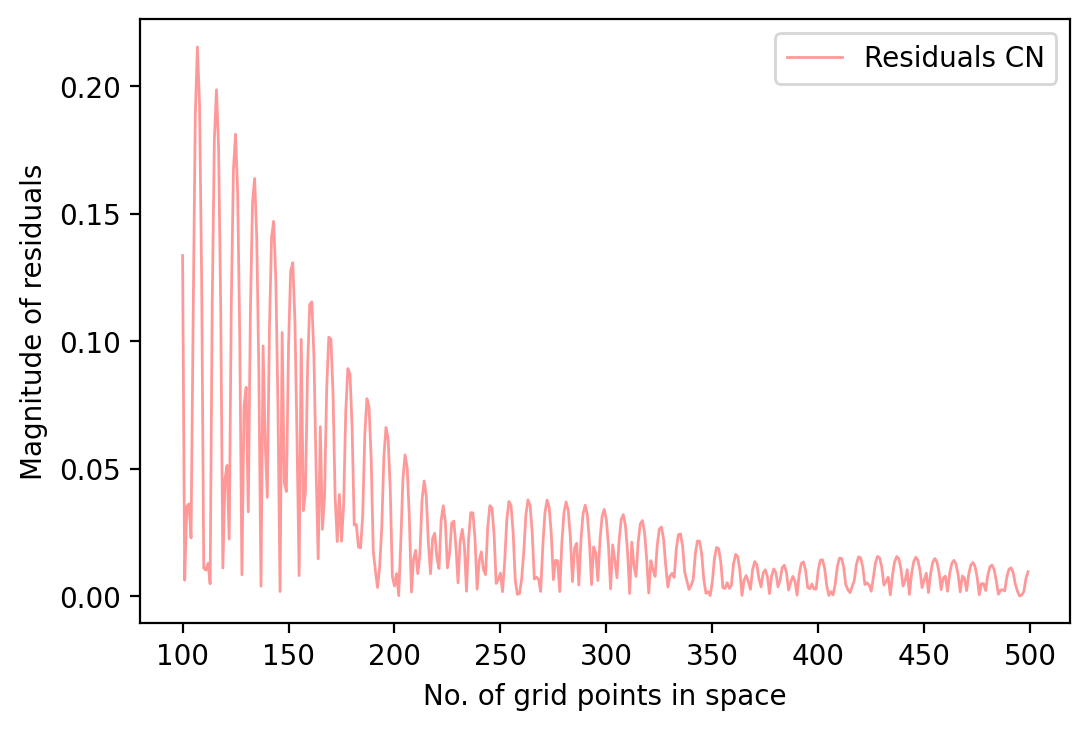

In [54]:
fig = plt.figure(dpi = 200)
plt.plot(x_range, residuals_ftcs, label='Residuals FTCS',lw=0.8,color='blue')
plt.plot(x_range, residuals_cn, label='Residuals CN',alpha=0.4,lw=1,color='red')
plt.xlabel("No. of grid points in space")
plt.ylabel("Magnitude of residuals")
plt.legend()
plt.show()

In [241]:
# using optimal grid sizes as determined above
res_ftcs= FDM(t_steps=61, x_steps=331, S0=120)
res_cn= FDM(t_steps=61, x_steps=331, S0=120,scheme="CN")

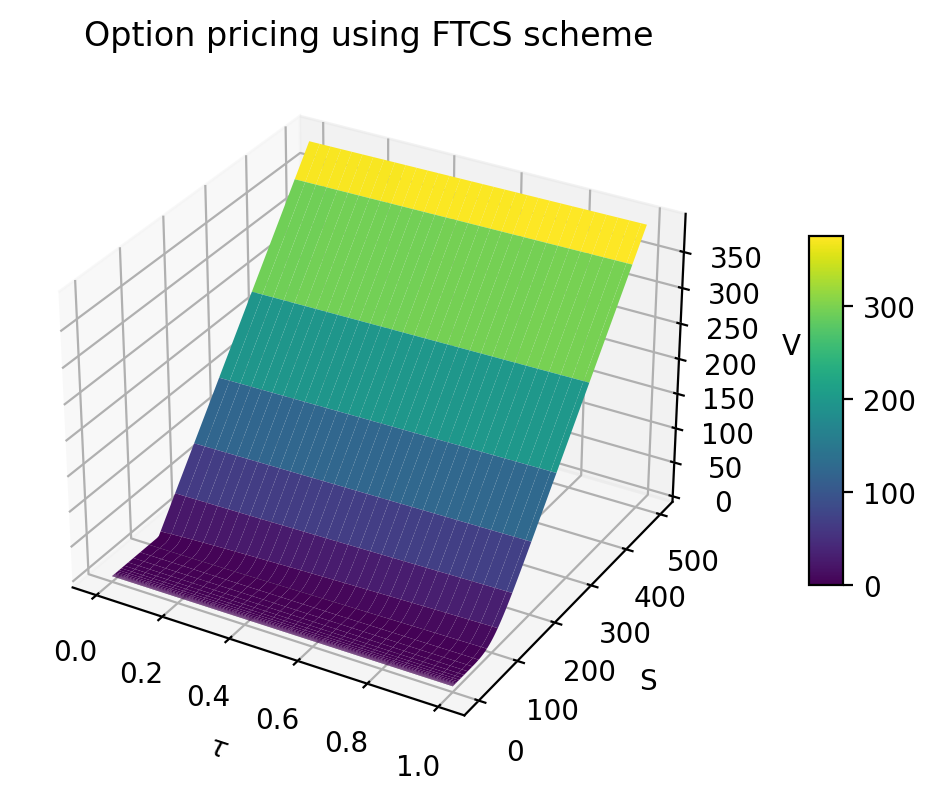

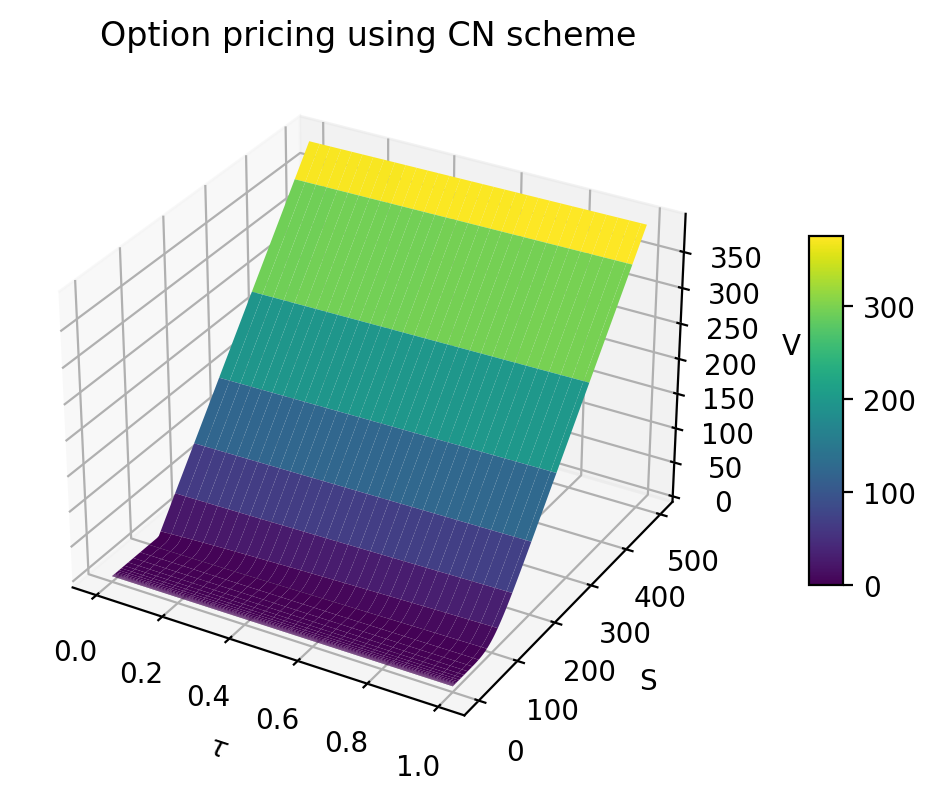

In [242]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, dpi=200)
x_ax, y_ax = np.meshgrid(res_ftcs[2], np.exp(res_ftcs[3]))
z_ax = np.transpose(res_ftcs[4])
surf = ax.plot_surface(x_ax, y_ax, z_ax, cmap=cm.viridis)
fig.colorbar(surf, shrink=0.5, aspect=10,pad=0.08)
ax.set_xlabel(r"$\tau$")
ax.set_ylabel("S")
ax.set_zlabel("V")
ax.set_title("Option pricing using FTCS scheme")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, dpi=200)
x_ax, y_ax = np.meshgrid(res_cn[2], np.exp(res_cn[3]))
z_ax = np.transpose(res_cn[4])
surf = ax.plot_surface(x_ax, y_ax, z_ax, cmap=cm.viridis)
fig.colorbar(surf, shrink=0.5, aspect=10, pad=0.08)
ax.set_xlabel(r"$\tau$")
ax.set_ylabel("S")
ax.set_zlabel("V")
ax.set_title("Option pricing using CN scheme")
plt.tight_layout()
plt.show()

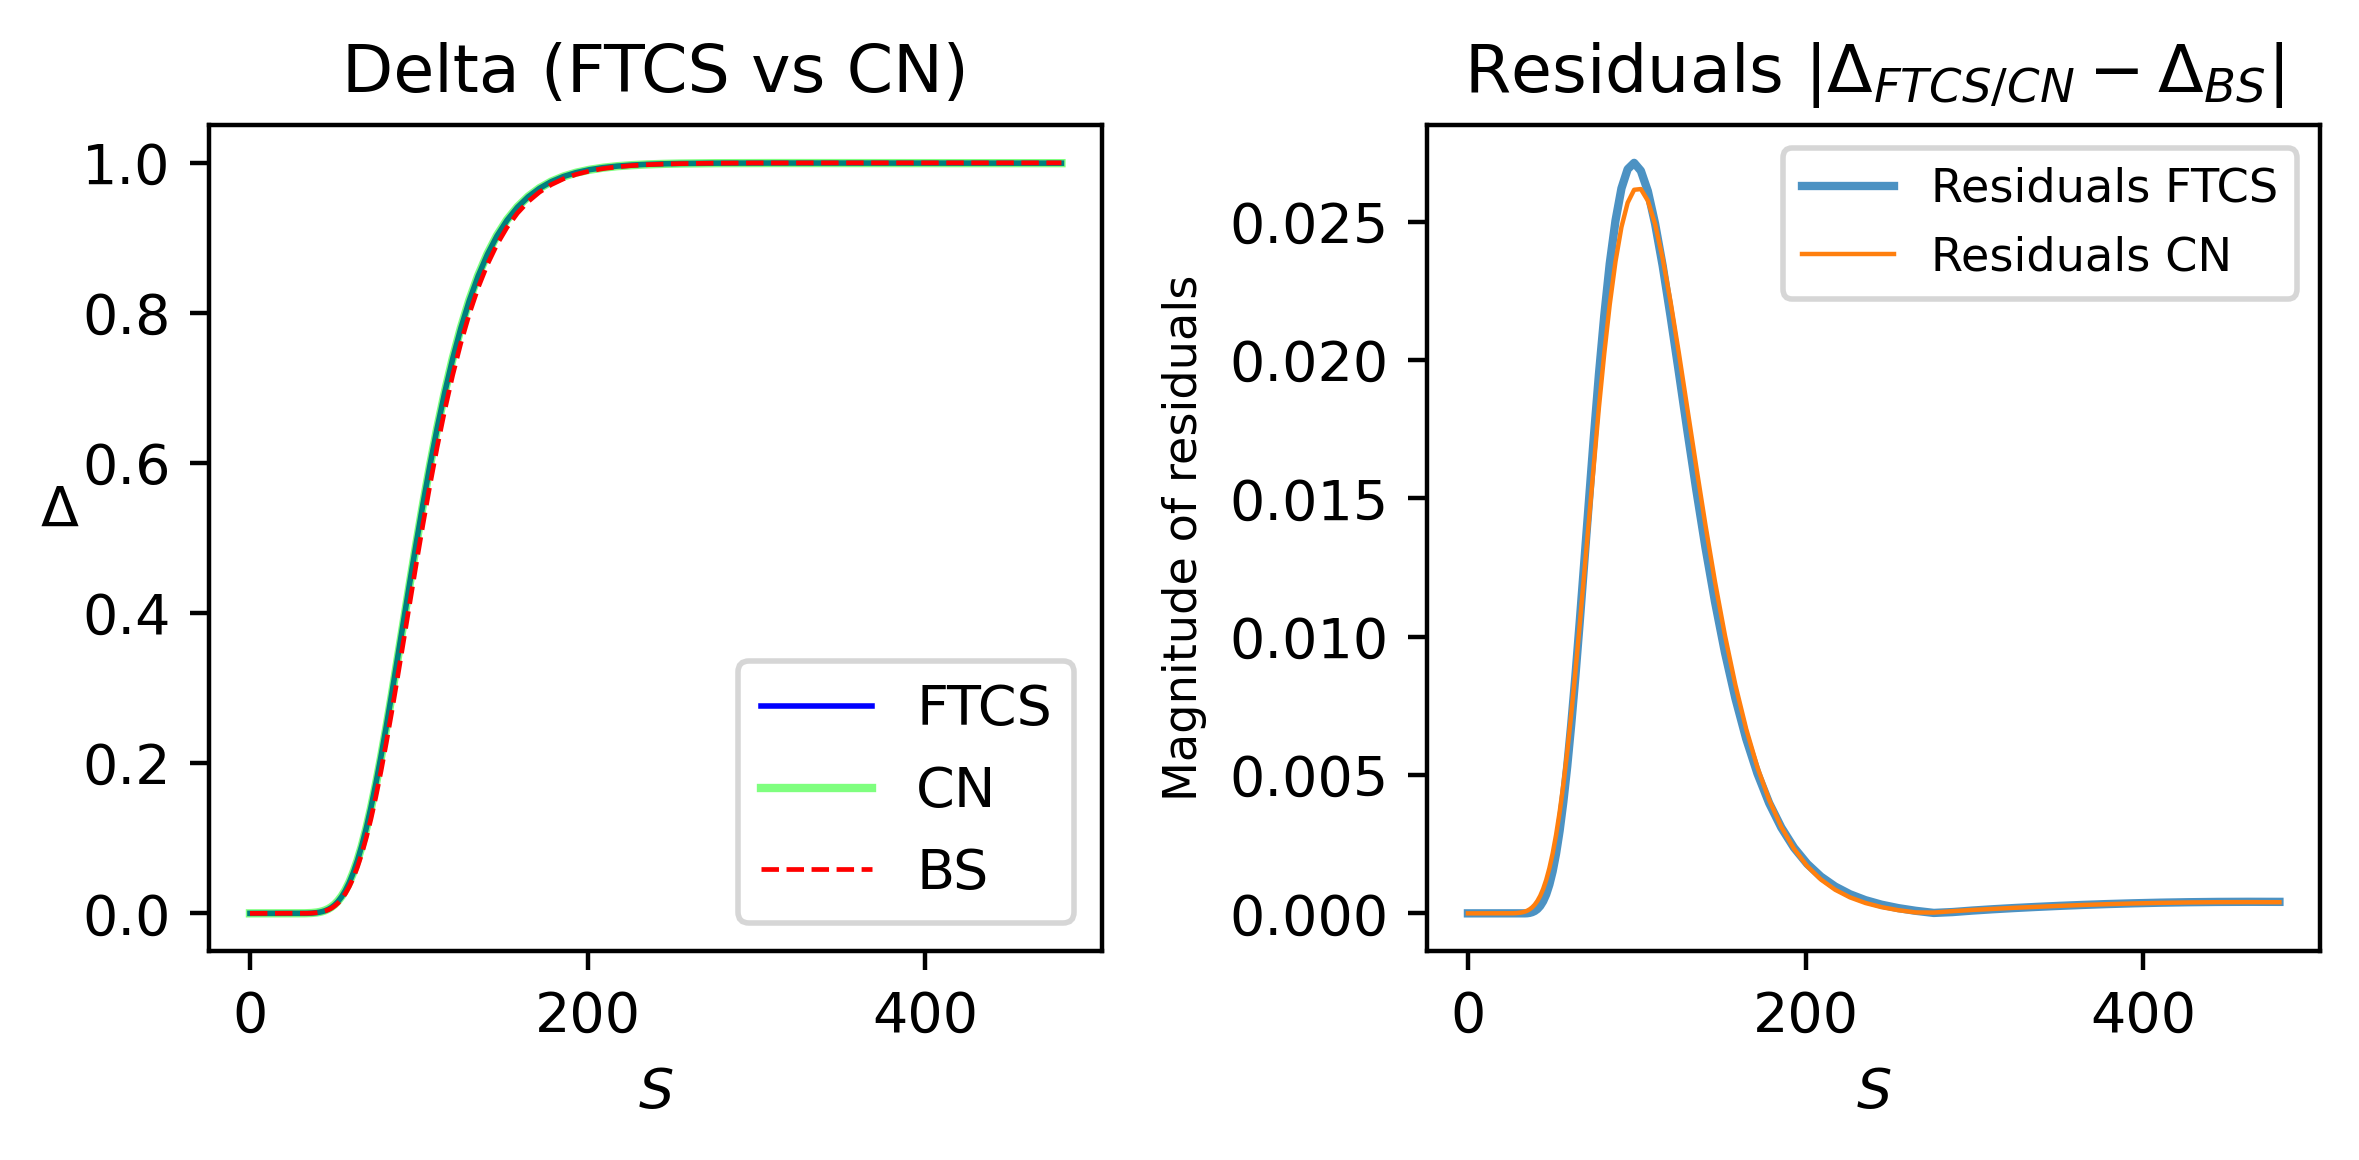

In [243]:
V0_ftcs = res_ftcs[1]
V0_cn = res_cn[1]
X = res_ftcs[3]
S = np.exp(X)

delta_ftcs = []
delta_bs = []
delta_cn = []
residuals_ftcs = []
residuals_cn = []

for i in range(S.size-1):
    del_bs = blackschol(S0=S[i])[1]
    delta_bs.append(del_bs)
    del_ftcs = (V0_ftcs[i+1]-V0_ftcs[i])/(S[i+1]-S[i])
    del_cn = (V0_cn[i+1]-V0_cn[i])/(S[i+1]-S[i])
    delta_ftcs.append(del_ftcs)
    delta_cn.append(del_cn)
    residuals_ftcs.append(abs(del_ftcs-del_bs))
    residuals_cn.append(abs(del_cn-del_bs))

fig, axs = plt.subplots(1,2,figsize=(6,3), dpi=400)
axs[0].plot(S[:-1], delta_ftcs,lw=1,color='blue',label='FTCS')
axs[0].plot(S[:-1], delta_cn,lw=1.5,color='lime',alpha=0.5,label='CN')
axs[0].plot(S[:-1], delta_bs,color='red',ls='--',lw=0.85,label="BS")

axs[0].set_xlabel(r"$S$")
axs[0].set_ylabel(r"$\Delta$").set_rotation(0)
axs[0].set_title('Delta (FTCS vs CN)')
axs[0].legend()
axs[1].plot(S[:-1], residuals_ftcs, label='Residuals FTCS',alpha=0.8)
axs[1].plot(S[:-1], residuals_cn, label='Residuals CN',lw=0.8)
axs[1].set_xlabel(r"$S$")
axs[1].set_ylabel("Magnitude of residuals", fontsize='small')
axs[1].set_title(r"Residuals $|\Delta_{FTCS/CN}-\Delta_{BS}|$")
axs[1].legend(fontsize='small')
plt.tight_layout()
plt.show()